In [28]:
import torch
import torch.nn.functional as F
from torch import nn
import pandas as pd
import numpy as np
import json
import pickle
import time
import re # for regular expressions
from sklearn.manifold import TSNE # for t-SNE
import matplotlib.pyplot as plt # for making figures
%matplotlib inline
%config InlineBackend.figure_format = 'retina' # to make graphs sharper
from pprint import pprint # pretty print
from sklearn.manifold import TSNE

In [29]:
with open('/content/word2int.pkl', 'rb') as f:
  word2int = pickle.load(f)

In [30]:
with open('/content/int2word.pkl', 'rb') as f:
  int2word = pickle.load(f)

In [31]:
block_size = 4 # context length: how many words do we take to predict the next one
num_layers = 3 # number of layers in the model
hidden_size = 1024 # size of the hidden layers in the model
emb_dim = 128 # embedding layer dimension
batch_size = 2048 # batch size
num_epochs = 150 # number of epochs to train for
learning_rate = 0.01 # learning rate for the optimizer
random_seed = 96 # random seed for reproducibility
activation_function = 'ReLU' # activation function to use
vocab_size = len(word2int.keys()) # vocab size

In [32]:
selected_words = [
    "war", "military", "battle", "fight", "soldier", "enemy",
    "power", "strength", "victory", "defeat", "courage",
    "honor", "sacrifice", "strategy", "tactics", "conflict",
    "peace", "truce", "alliance", "hero", "nation",
    "kingdom", "leader", "general", "enemy",
    "command", "victorious", "fallen", "foe", "enemy",
    "loss", "destruction", "freedom", "loyalty",
    "trust", "family", "home", "love", "friendship",
    "connection", "society", "community", "class", "status",
    "wealth", "poverty", "grief", "sorrow", "joy",
    "hope", "fear", "despair", "nature", "beauty",
    "life", "death", "struggle", "dream", "goal",
    "desire", "emotion", "thought", "idea", "wisdom",
    "knowledge", "truth", "reality", "experience", "existence",
    "the", "and", "or", "not", "a", "an", "is", "was", "be",
    "are", "of", "to", "in", "for", "on", "with", "as",
    "that", "by", "from", "it", "this", "which", "who",
    "at", "but", "if", "so", "there", "all", "some",
    "any", "many", "more", "few", "much", "such", "like",
    "than", "because", "since", "until", "while", "when",
    "may", "can", "could", "should", "would", "shall",
    "might", "have", "has", "had", "do", "does", "did",
    "will", "yet", "now", "then", "here", "away",
    "together", "apart", "before", "after", "during",
    "about", "against", "under", "over", "between",
    "within", "without", "toward", "through", "around",
    "also", "either", "neither", "although", "despite",
    "although", "while", "where", "when", "why",
    "how", "if", "unless", "although", "upon",
    "whereas", "both", "either", "neither", "thus",
    "therefore"
]

In [33]:
def sine_init(m): # SIREN initialization for gradient stability when working with sin activation function
    if isinstance(m, nn.Linear):
        input_dim = m.weight.size(1)
        std = 1 / input_dim  # scale factor for stability
        nn.init.uniform_(m.weight, -std, std)
        if m.bias is not None:
            nn.init.zeros_(m.bias)

class NextWord(nn.Module):
  def __init__(self, block_size, vocab_size, emb_dim, hidden_size, activation_function,num_layers=3): # init method defines the architecture of the neural network
    super().__init__() # calls the superclass and its constructor
    self.emb = nn.Embedding(vocab_size, emb_dim) # embedding layer
    self.layers = nn.ModuleList() # list of layers
    hl_1 = nn.Linear(block_size * emb_dim, hidden_size)
    if activation_function == 'Sin':
      sine_init(hl_1)
    self.layers.append(hl_1) # first layer, maps from (block_size * emb_dim) neurons to (hidden_size) neurons
    for i in range(num_layers): # creating hidden layers
      layer = nn.Linear(int(hidden_size/(2**i)), int(hidden_size/(2**(i+1))))
      if activation_function == 'Sin':
        sine_init(layer)
      self.layers.append(layer)
    self.layers.append(nn.Linear(int(hidden_size/(2**num_layers)), vocab_size)) # output layer
    if activation_function == 'ReLU':
      self.activation = nn.ReLU()
    elif activation_function == 'Sin':
      self.activation = lambda x: torch.sin(x)

  def forward(self, x):
    x = self.emb(x) # embedding layer
    x = x.view(x.shape[0], -1) # flatten the embedding layer
    for layer in self.layers[:-1]: # passing through the layers
      x = layer(x)
      x = self.activation(x)
    x= self.layers[-1](x) # output layer
    return x

In [34]:
selected_indices = []
for word in selected_words:
  if word in word2int.keys():
    selected_indices.append(word2int[word])

<ipython-input-35-072f039d6327>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/model_128_4_ReLU_96.pth'))


torch.Size([168, 128])
torch.Size([168])
168


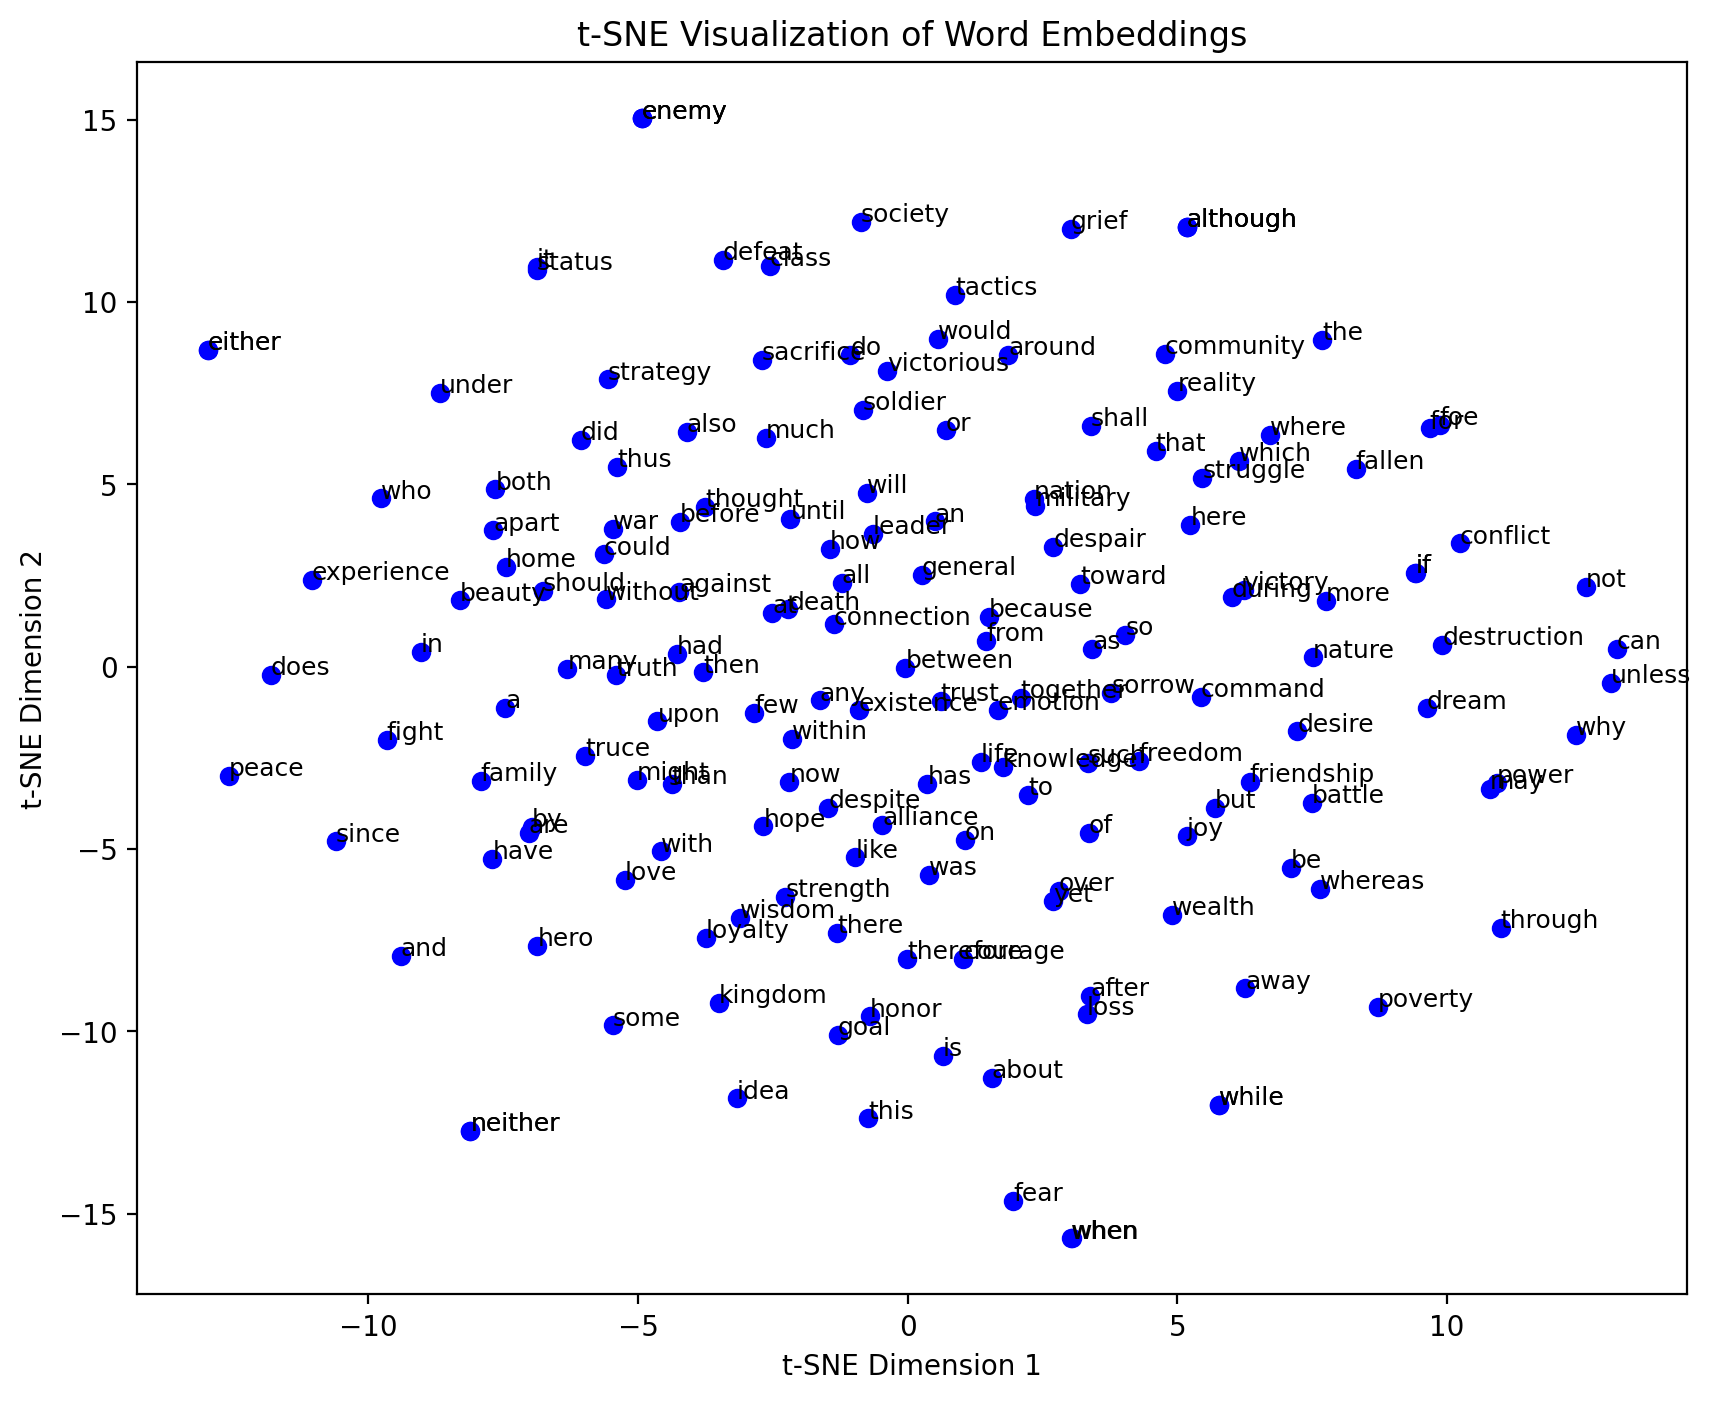

In [35]:
model = NextWord(block_size, vocab_size, emb_dim, hidden_size,activation_function)
model.load_state_dict(torch.load('/content/model_128_4_ReLU_96.pth'))
model.eval()  # Setting the model to evaluation mode

#  words to indices using word2int dictionary

inputs = torch.tensor(selected_indices, dtype = torch.long)

embeddings = model.emb(inputs)
print(embeddings.shape)
print(inputs.shape)


# embeddings from the embedding layer
with torch.no_grad():  # For disabling gradient calculations
    embeddings = model.emb(inputs)  # Use the embedding layer directly

# embeddings to numpy for t-SNE
embeddings_np = embeddings.numpy()

print(len(embeddings_np))

tsne = TSNE(n_components=2, random_state=96, perplexity = 20)
embeddings_tsne = tsne.fit_transform(embeddings_np)

plt.figure(figsize=(10, 8))
plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], color='blue')

# labelling each point based on the int2word dictionary
for i, idx in enumerate(selected_indices):
    word = int2word[idx]
    plt.annotate(word, (embeddings_tsne[i, 0], embeddings_tsne[i, 1]), fontsize=9)

plt.title("t-SNE Visualization of Word Embeddings")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.show()


In [36]:
with open('/content/processed_warandpeace.txt', 'r') as f:
  pr_text = f.read()

In [37]:
pr_text = pr_text.split()
frequency = {}
for word in word2int.keys():
  frequency[word] = pr_text.count(word)
filtered = []
for word in frequency.keys():
  if frequency[word] > 500:
    filtered.append(word)
print(len(filtered))

146


In [40]:
print(frequency)

{' ': 0, '.': 30577, '.2': 1, '.ar': 1, '.ate': 2, '.ly': 1, '.n': 2, '.not': 1, '.o': 1, '.of': 1, '.s': 2, '.u': 1, '1': 21, '10': 3, '100': 1, '10000': 1, '100000': 1, '102': 2, '11': 4, '110': 1, '120': 1, '130': 1, '13th': 3, '140': 1, '15': 1, '150': 1, '15000': 1, '150000': 1, '154': 1, '15y': 1, '160': 1, '160000': 1, '17': 1, '178': 1, '1789': 3, '1797': 1, '17th': 1, '18': 1, '1805': 20, '18056': 1, '1806': 8, '1807': 13, '1808': 3, '1809': 16, '1810': 2, '1811': 6, '1812': 45, '1813': 12, '1815': 1, '1820': 4, '18th': 1, '1st': 1, '2': 41, '20': 2, '217': 1, '22': 2, '22nd': 1, '23': 1, '23rd': 1, '24': 2, '24th': 1, '25': 2, '25th': 1, '26': 1, '27': 1, '27th': 1, '3': 15, '30': 4, '30000': 1, '31': 1, '3rd': 4, '4': 5, '40': 1, '4th': 1, '4x': 1, '5': 4, '50': 1, '6': 4, '60': 1, '62': 1, '666': 6, '671': 1, '6me': 1, '6th': 2, '7': 3, '70': 1, '700': 1, '70000': 1, '7th': 1, '8': 2, '80': 1, '800': 2, '80000': 1, '86th': 1, '8th': 1, '9': 3, '90': 1, '9th': 1, 'a': 10540,

In [41]:
filtered = []
for word in frequency.keys():
  if frequency[word] > 550:
    filtered.append(word)
print(len(filtered))

132


In [42]:
print(filtered)

['.', 'a', 'about', 'after', 'again', 'all', 'an', 'and', 'andrew', 'another', 'are', 'army', 'as', 'asked', 'at', 'away', 'be', 'been', 'before', 'began', 'but', 'by', 'came', 'come', 'could', 'count', 'did', 'do', 'down', 'eyes', 'face', 'felt', 'first', 'for', 'french', 'from', 'go', 'had', 'has', 'have', 'he', 'head', 'her', 'him', 'himself', 'his', 'how', 'i', 'if', 'in', 'into', 'is', 'it', 'its', 'just', 'know', 'left', 'life', 'like', 'little', 'looked', 'man', 'mary', 'me', 'men', 'more', 'moscow', 'my', 'natasha', 'nicholas', 'no', 'not', 'now', 'of', 'old', 'on', 'one', 'only', 'or', 'other', 'our', 'out', 'over', 'pierre', 'prince', 'princess', 'room', 'rostov', 'said', 'same', 'say', 'see', 'seemed', 'she', 'so', 'some', 'something', 'still', 'such', 'that', 'the', 'their', 'them', 'then', 'there', 'these', 'they', 'this', 'those', 'thought', 'time', 'to', 'two', 'up', 'very', 'was', 'we', 'well', 'went', 'were', 'what', 'when', 'where', 'which', 'who', 'will', 'with', 'wi

In [43]:
filtered_indices = []
for word in filtered:
  if word in word2int.keys():
    filtered_indices.append(word2int[word])

In [44]:
print(len(filtered_indices))

132


torch.Size([132, 128])
torch.Size([132])
132


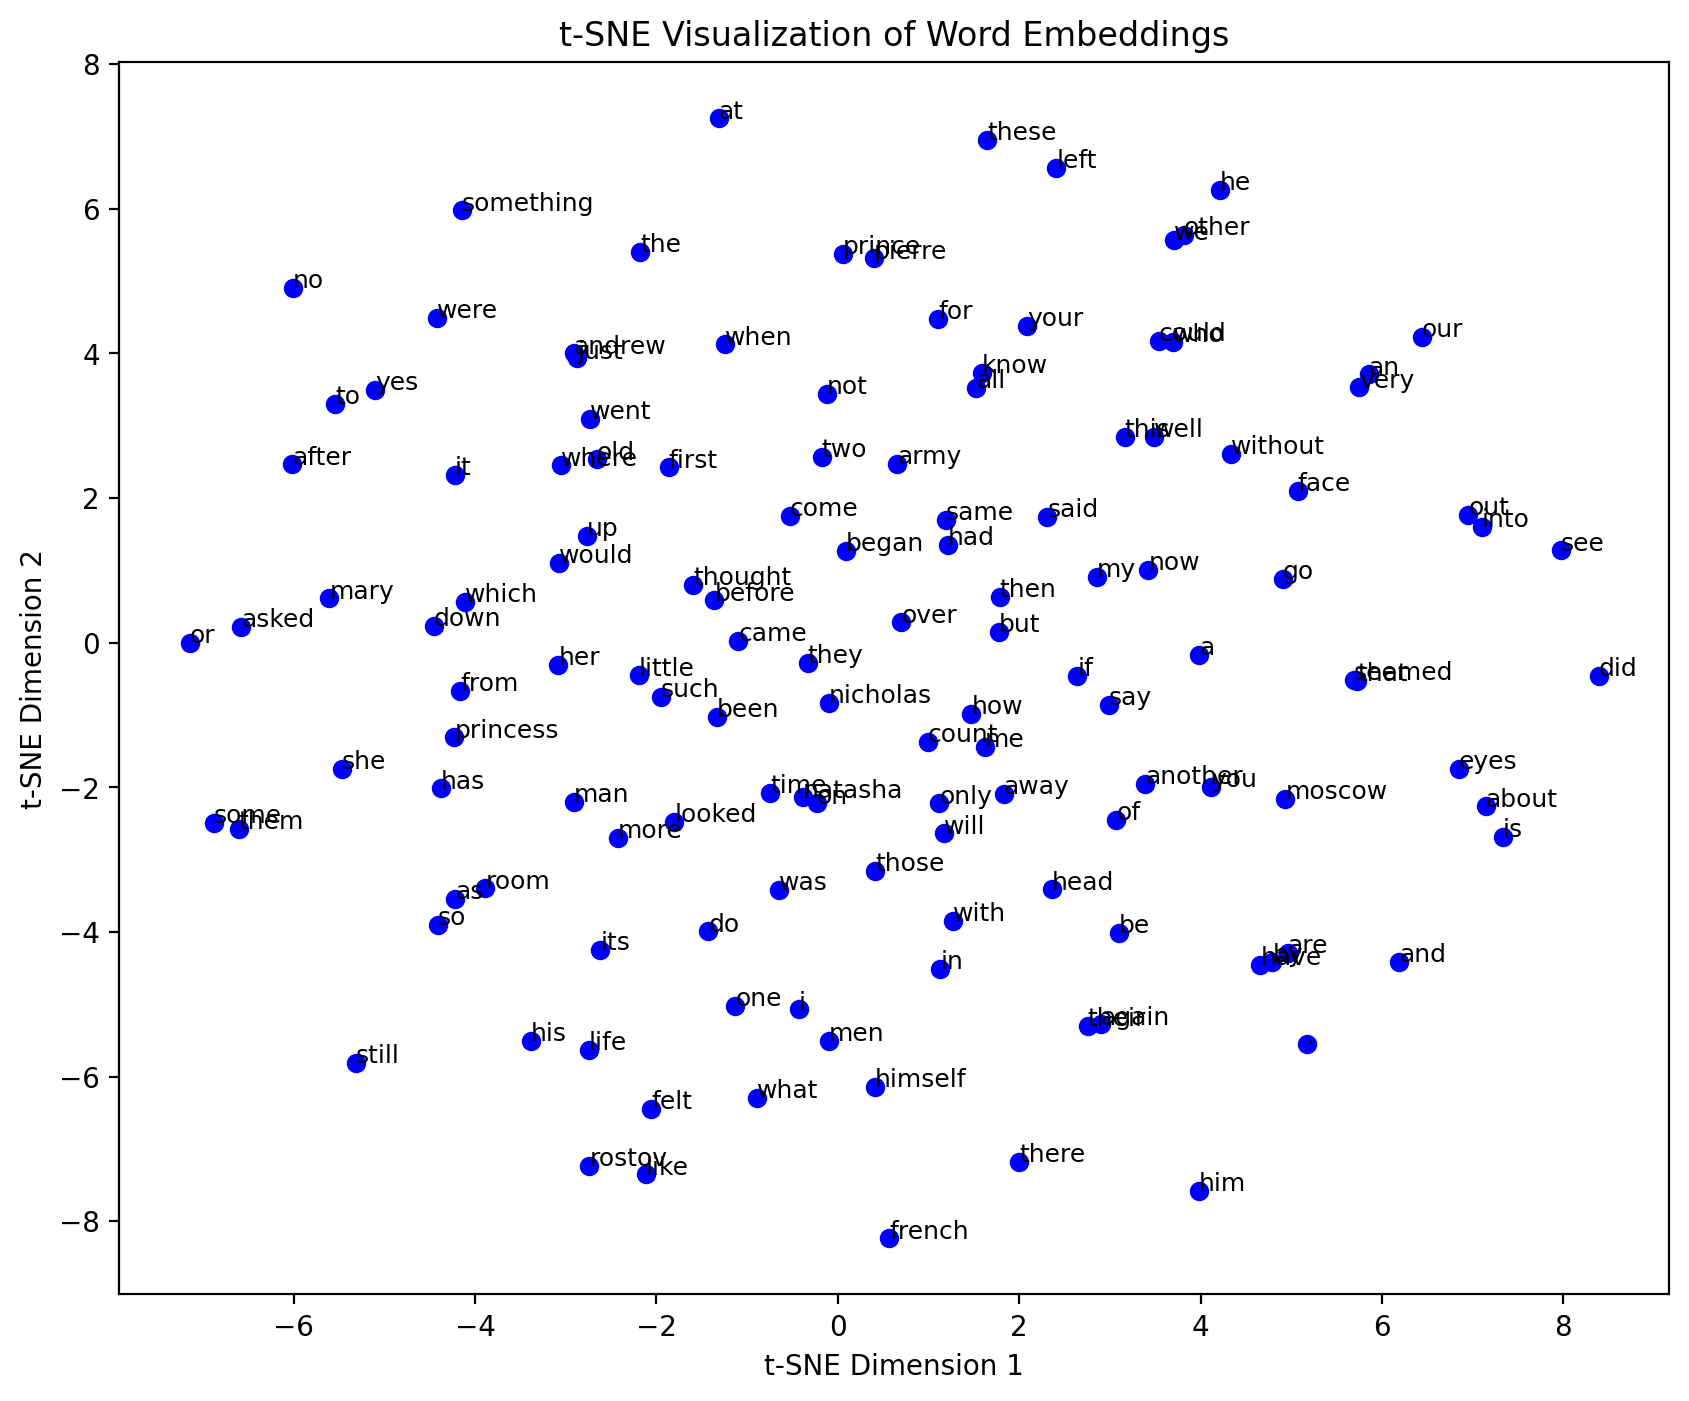

In [45]:
inputs = torch.tensor(filtered_indices, dtype = torch.long)

embeddings = model.emb(inputs)
print(embeddings.shape)
print(inputs.shape)


# embeddings from the embedding layer
with torch.no_grad():  # For disabling gradient calculations
    embeddings = model.emb(inputs)  # Use the embedding layer directly

# embeddings to numpy for t-SNE
embeddings_np = embeddings.numpy()

print(len(embeddings_np))
tsne = TSNE(n_components=2, random_state=96, perplexity = 20)
embeddings_tsne = tsne.fit_transform(embeddings_np)

plt.figure(figsize=(10, 8))
plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], color='blue')

# labelling each point based on the int2word dictionary
for i, idx in enumerate(filtered_indices):
    word = int2word[idx]
    plt.annotate(word, (embeddings_tsne[i, 0], embeddings_tsne[i, 1]), fontsize=9)

plt.title("t-SNE Visualization of Word Embeddings")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.show()
